<a href="https://colab.research.google.com/github/CarolKSD/Deforestation-Analysis/blob/main/Deforestation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Cover and Deforestation Analysis Project

This project analyzes land cover changes and deforestation trends in the **Xingu National Park region** using Google Earth Engine and Python. The key objectives are:

1. **Calculate NDVI** (Normalized Difference Vegetation Index) for each year to monitor vegetation health.
2. **Classify land cover** into four main classes: Forest, Water, Agriculture, and Exposed Soil.
3. **Detect and analyze changes** between land cover classes over time, such as deforestation and reforestation trends.
4. **Export results** as visualizations (graphs, maps) and structured data (CSV files) for further analysis.

In [1]:
# Install necessary libraries
!pip install earthengine-api geemap

# Import libraries
import ee
import geemap

# Authenticate and initialize the Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-carolineksdalmazzo")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00


## Step 1: Define Region of Interest (Xingu National Park)

The region of interest (ROI) is defined as the boundaries of the Xingu National Park, wich is located in the northern part of the state of Mato Grosso, Brazil, and spans a small portion of southern Pará. It is situated in the southern Amazon region, bordered by the Xingu River, which is one of the major tributaries of the Amazon River.

In [2]:
# Define the region of interest (Xingu National Park)
xingu_roi = ee.Geometry.Polygon([
    [
        [-54.06229212755538, -10.55648775892796],
        [-54.06229212755538, -13.029797196926019],
        [-52.49124720568038, -13.029797196926019],
        [-52.49124720568038, -10.55648775892796]
    ]
])

## Step 2: Calculate NDVI for Each Year

**NDVI (Normalized Difference Vegetation Index)** is calculated for each year using Landsat satellite imagery. NDVI is a key metric for monitoring vegetation health. The process involves:
1. Filtering Landsat images for the specified year and region.
2. Calculating NDVI.
3. Storing the results for each year for further analysis.

The output is an annual NDVI map for the region

In [5]:
# List of years for analysis
years = list(range(2014, 2025))

# Function to calculate NDVI
def calculate_ndvi(image):
    return image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Process Landsat images and calculate NDVI for each year
ndvi_collection = []
for year in years:
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Filter Landsat collection for the specific year
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(xingu_roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUD_COVER', 50))

    # Create a median composite and calculate NDVI
    image = collection.median().clip(xingu_roi)
    ndvi = calculate_ndvi(image).set('year', year)
    ndvi_collection.append(ndvi)

# Combine NDVIs into an image collection
ndvi_collection = ee.ImageCollection(ndvi_collection)

# Export NDVI images to Google Drive
for year in years:
    ndvi_image = ndvi_collection.filter(ee.Filter.eq('year', year)).first()

    # Export NDVI image
    task = ee.batch.Export.image.toDrive(
        image=ndvi_image,
        description=f"NDVI_{year}",
        folder="EarthEngineImages",
        fileNamePrefix=f"NDVI_{year}",
        scale=30,
        region=xingu_roi,
        maxPixels=1e10
    )
    task.start()
    print(f"Exporting NDVI for {year}.")

Exporting NDVI for 2014.
Exporting NDVI for 2015.
Exporting NDVI for 2016.
Exporting NDVI for 2017.
Exporting NDVI for 2018.
Exporting NDVI for 2019.
Exporting NDVI for 2020.
Exporting NDVI for 2021.
Exporting NDVI for 2022.
Exporting NDVI for 2023.
Exporting NDVI for 2024.


In [ ]:
# Initialize the map
Map1 = geemap.Map()
Map1.centerObject(xingu_roi, 8)

# Add NDVI layers to the map
for year in years:
    ndvi_image = ndvi_collection.filter(ee.Filter.eq('year', year)).first()
    Map1.addLayer(ndvi_image, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'NDVI {year}')
Map1

Map(center=[-11.792361078050224, -53.276769666618065], controls=(WidgetControl(options=['position', 'transpare…

This section detects deforestation by calculating the NDVI difference between consecutive years. Areas with significant vegetation loss (NDVI < -0.2) are masked and labeled for each period.

In [ ]:
# Detect deforestation between consecutive years
deforestation_masks = []
for i in range(len(years) - 1):
    year1 = years[i]
    year2 = years[i + 1]

    ndvi1 = ndvi_collection.filter(ee.Filter.eq('year', year1)).first()
    ndvi2 = ndvi_collection.filter(ee.Filter.eq('year', year2)).first()

    # Calculate NDVI difference
    ndvi_diff = ndvi2.subtract(ndvi1).rename('NDVI_Change')

    # Deforestation mask (significant vegetation loss)
    deforestation_mask = ndvi_diff.lt(-0.2).selfMask().set('period', f'{year1}-{year2}')
    deforestation_masks.append(deforestation_mask)

# Combine deforestation masks into an image collection
deforestation_collection = ee.ImageCollection(deforestation_masks)

# Export deforestation masks to Google Drive
for i in range(len(years) - 1):
    period = f"{years[i]}-{years[i + 1]}"
    deforestation_image = deforestation_collection.filter(ee.Filter.eq('period', period)).first()

    # Export deforestation mask
    task = ee.batch.Export.image.toDrive(
        image=deforestation_image,
        description=f"Deforestation_{period}",
        folder="EarthEngineImages",
        fileNamePrefix=f"Deforestation_{period}",
        scale=30,
        region=xingu_roi,
        maxPixels=1e10
    )
    task.start()
    print(f"Exporting deforestation mask for {period}.")

Exporting deforestation mask for 2014-2015.
Exporting deforestation mask for 2015-2016.
Exporting deforestation mask for 2016-2017.
Exporting deforestation mask for 2017-2018.
Exporting deforestation mask for 2018-2019.
Exporting deforestation mask for 2019-2020.
Exporting deforestation mask for 2020-2021.
Exporting deforestation mask for 2021-2022.
Exporting deforestation mask for 2022-2023.
Exporting deforestation mask for 2023-2024.


In [ ]:
# Initialize the map
Map2 = geemap.Map()
Map2.centerObject(xingu_roi, 8)

# Add deforestation layers to the map
for i in range(len(years) - 1):
    period = f"{years[i]}-{years[i+1]}"
    deforestation_image = deforestation_collection.filter(ee.Filter.eq('period', period)).first()
    Map2.addLayer(deforestation_image, {'palette': 'red'}, f'Deforestation {period}')
Map2

Map(center=[-11.792361078050224, -53.276769666618065], controls=(WidgetControl(options=['position', 'transpare…

Now, we are calculating the deforested area for each period by counting the pixels in the NDVI-based deforestation masks. The pixel count is converted to area in km², and the results are stored for each year.

In [ ]:
# Pixel area in square meters (30m resolution)
pixel_area = 30 * 30  # 900 m² per pixel

# Calculate deforested area for each period
deforestation_areas = []
for i in range(len(years) - 1):
    period = f"{years[i]}-{years[i+1]}"
    deforestation_image = deforestation_collection.filter(ee.Filter.eq('period', period)).first()

    # Calculate the number of deforested pixels
    deforested_pixels = deforestation_image.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=xingu_roi,
        scale=30,
        maxPixels=1e10
    ).get('NDVI_Change')

    # Convert to area in km²
    deforested_area_km2 = ee.Number(deforested_pixels).multiply(pixel_area).divide(1e6)
    deforestation_areas.append((period, deforested_area_km2.getInfo()))

# Print deforestation areas
for period, area in deforestation_areas:
    print(f"Deforested area for {period}: {area:.2f} km²")

# Export deforestation trends to CSV
import csv

# Prepare deforestation data
deforestation_data = []
for period, area in deforestation_areas:
    deforestation_data.append({'Period': period, 'Deforested Area (km²)': area})

# Write deforestation data to a CSV file
with open('deforestation_trends.csv', 'w', newline='') as csvfile:
    fieldnames = ['Period', 'Deforested Area (km²)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(deforestation_data)

print("Deforestation trends exported to deforestation_trends.csv.")

Deforested area for 2014-2015: 43.94 km²
Deforested area for 2015-2016: 20.29 km²
Deforested area for 2016-2017: 48.38 km²
Deforested area for 2017-2018: 40.38 km²
Deforested area for 2018-2019: 19.04 km²
Deforested area for 2019-2020: 85.05 km²
Deforested area for 2020-2021: 98.26 km²
Deforested area for 2021-2022: 56.86 km²
Deforested area for 2022-2023: 55.22 km²
Deforested area for 2023-2024: 52.13 km²
Deforestation trends exported to deforestation_trends.csv.


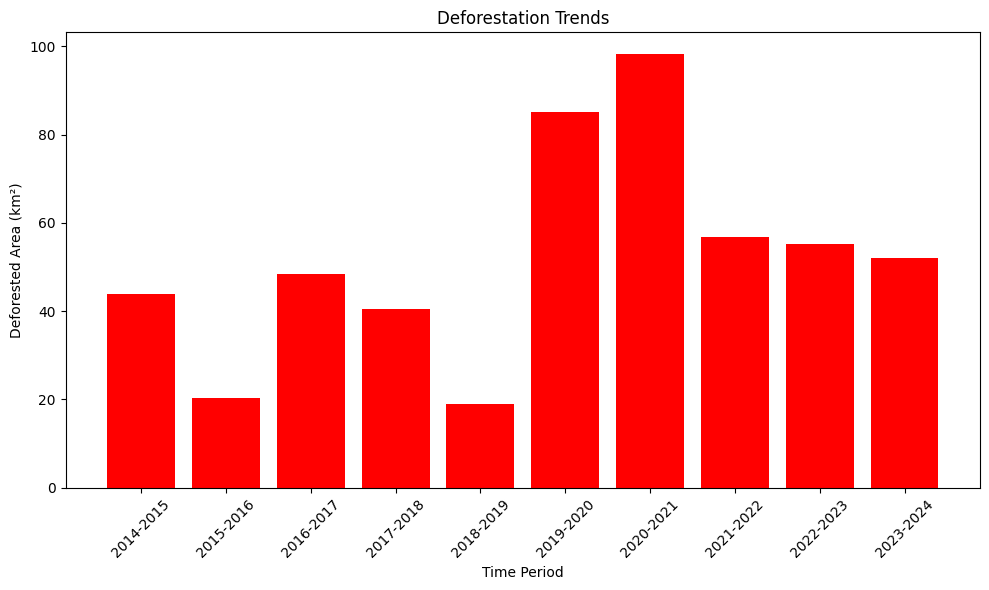

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot deforestation trends
periods = [item[0] for item in deforestation_areas]
areas = [item[1] for item in deforestation_areas]

plt.figure(figsize=(10, 6))
plt.bar(periods, areas, color='red')
plt.xlabel('Time Period')
plt.ylabel('Deforested Area (km²)')
plt.title('Deforestation Trends')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 3: Land Cover Classification

In this step, we classify land cover into four classes: Forest, Water, Agriculture, and Exposed Soil.

1. Training points are defined for each class, representing known land cover types.
2. These points are used to train a Random Forest Classifier on Landsat imagery for each year.
3. The classifier assigns each pixel in the imagery to one of the four classes based on spectral bands.
4. The classified images are saved into a collection and exported to Google

In [4]:
# List of years for analysis
years = list(range(2014, 2025))

# Training points for land cover classification
forest_points = [
    ee.Feature(ee.Geometry.Point([-53.483, -12.371]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.290, -12.504]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.155, -12.304]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.274, -11.453]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.807, -11.855]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.743, -11.580]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.377, -11.171]), {'class': 0}),
    ee.Feature(ee.Geometry.Point([-53.480, -12.256]), {'class': 0})
]
water_points = [
    ee.Feature(ee.Geometry.Point([-53.262, -11.236]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.242, -11.225]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.228, -11.245]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.445, -12.119]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.510, -11.077]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.496, -11.075]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.324, -11.330]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.360, -11.329]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.628, -12.005]), {'class': 1}),
    ee.Feature(ee.Geometry.Point([-53.300, -12.226]), {'class': 1})
]
agriculture_points = [
    ee.Feature(ee.Geometry.Point([-52.818, -12.177]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.801, -12.176]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.876, -12.108]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.915, -11.987]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.826, -11.170]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.837, -11.195]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.823, -11.730]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.955, -11.929]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.974, -11.933]), {'class': 2}),
    ee.Feature(ee.Geometry.Point([-52.930, -12.051]), {'class': 2})
]
exposed_soil_points = [
    ee.Feature(ee.Geometry.Point([-52.891, -12.018]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-52.883, -12.025]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-53.381, -12.232]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-53.552, -12.917]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-53.198, -11.620]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-52.868, -10.904]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-52.869, -10.905]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-53.636, -11.120]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-53.211, -12.355]), {'class': 3}),
    ee.Feature(ee.Geometry.Point([-53.215, -12.372]), {'class': 3})
]

# Combine all points into a single collection
training_data = ee.FeatureCollection(forest_points + water_points + agriculture_points + exposed_soil_points)

# Bands used for classification
bands = ['SR_B4', 'SR_B3', 'SR_B2', 'SR_B5']

# Perform classification for each year
classified_collection = []
for year in years:
    landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(f'{year}-01-01', f'{year}-12-31') \
        .filterBounds(xingu_roi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 30)) \
        .median() \
        .clip(xingu_roi)

    # Train classifier
    training = landsat.select(bands).sampleRegions(
        collection=training_data,
        properties=['class'],
        scale=30
    )
    classifier = ee.Classifier.smileRandomForest(300).train(
        features=training,
        classProperty='class',
        inputProperties=bands
    )

    # Apply classifier
    classified = landsat.select(bands).classify(classifier).set('year', year)
    classified_collection.append(classified)

# Combine classified images into a collection
classified_collection = ee.ImageCollection(classified_collection)

Model Validation: The training data is split (70% training, 30% validation) to evaluate the classifier. A confusion matrix and accuracy score are generated to assess performance

In [6]:
# Split training data into training and validation sets
training_with_random = training.randomColumn('random')

# 70% for training
training_partition = training_with_random.filter(ee.Filter.lt('random', 0.7))

# 30% for validation
validation_partition = training_with_random.filter(ee.Filter.gte('random', 0.7))

# Train classifier with training partition
trained_classifier = ee.Classifier.smileRandomForest(300).train(
    features=training_partition,
    classProperty='class',
    inputProperties=bands
)

# Classify validation data
validation = validation_partition.classify(trained_classifier)

# Generate confusion matrix
confusion_matrix = validation.errorMatrix('class', 'classification')
print('Confusion Matrix:', confusion_matrix.getInfo())
print('Accuracy:', confusion_matrix.accuracy().getInfo())

Confusion Matrix: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 1], [1, 0, 0, 2]]
Accuracy: 0.75


In [7]:
# Initialize the map
Map3 = geemap.Map()
Map3.centerObject(xingu_roi, 8)

# Define color palette and legend
legend_dict = {
    "Forest": (0, 255, 0), # Green
    "Water": (0, 0, 255), # Blue
    "Agriculture": (255, 255, 0), # Yellow
    "Exposed Soil": (255, 42, 42) # Brown
}

# Get a list of hex colors from legend_dict
palette = [f"#{r:02x}{g:02x}{b:02x}" for r, g, b in legend_dict.values()]

# Add classified land cover layers to the map
for year in years:
    classified_image = classified_collection.filter(ee.Filter.eq('year', year)).first()

    # Add the classified image to the map with the defined palette
    Map3.addLayer(
        classified_image,
        {
            'min': 0,
            'max': 3,
            'palette': palette
        },
        f"Classified {year}"
    )

# Add the legend to the map
Map3.add_legend(title="Land Cover Classes", legend_dict=legend_dict)

# Display the map
Map3

Map(center=[-11.792361078050224, -53.276769666618065], controls=(WidgetControl(options=['position', 'transpare…

In [ ]:
# Export classified images
for year in years:
    classified_image = classified_collection.filter(ee.Filter.eq('year', year)).first()

    # Apply palette to the images for export
    vis_params = {
        'min': 0,
        'max': 3,
        'palette': palette
    }
    classified_with_palette = classified_image.visualize(**vis_params)

    # Export to Google Drive
    task = ee.batch.Export.image.toDrive(
        image=classified_with_palette,
        description=f"Classified_{year}",
        folder="EarthEngineImages",
        fileNamePrefix=f"Classified_{year}",
        scale=30,
        region=xingu_roi,
        maxPixels=1e13  # Adjust if needed
    )
    task.start()
    print(f"Exporting Classified_{year} to Google Drive...")

Now, we are calculating the area and percentage of each land cover class for each year

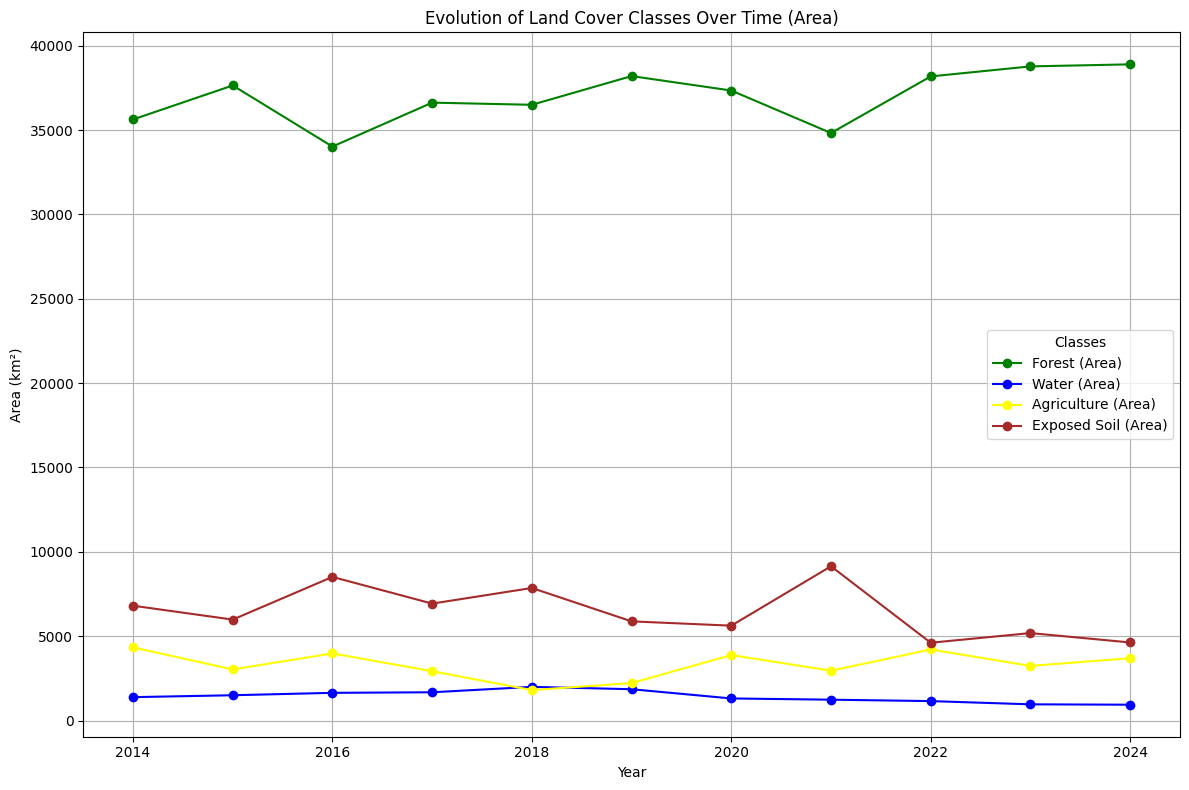

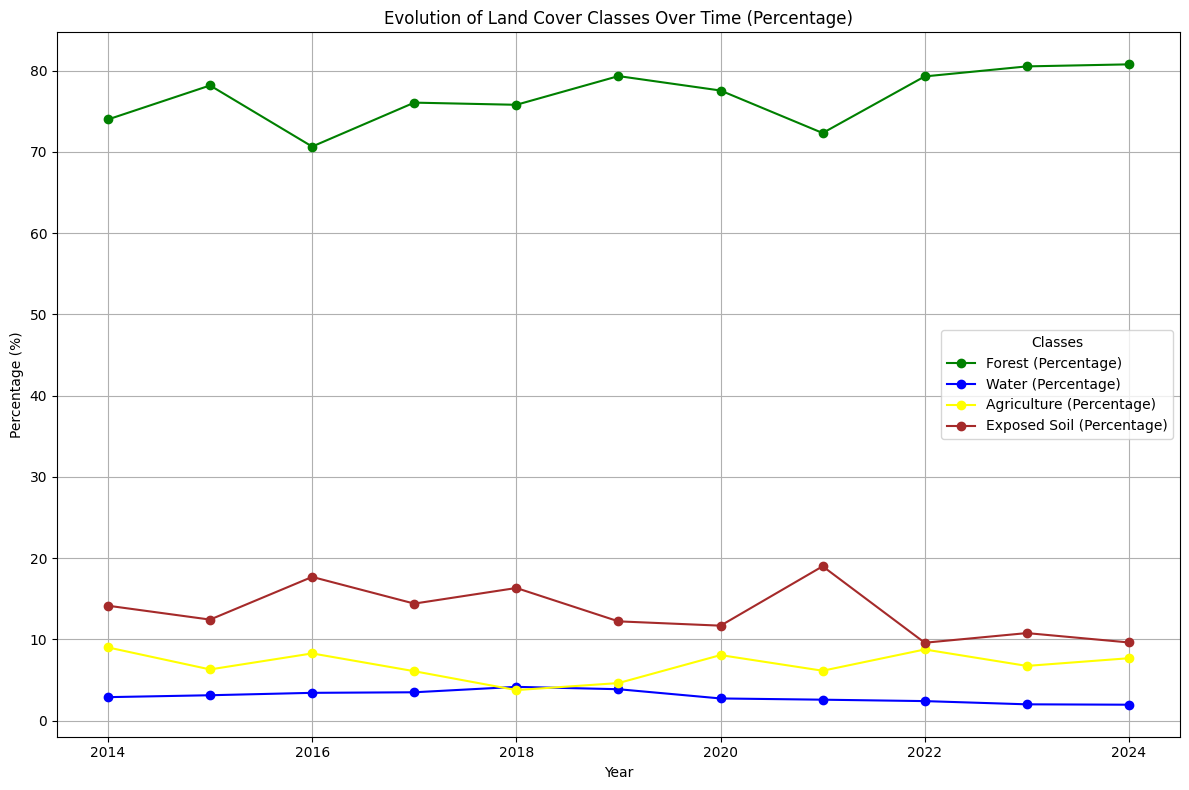

Class evolution data (with percentage) exported to class_evolution_with_percentage.csv.


In [ ]:
# Define class names and corresponding colors
class_names = {0: "Forest", 1: "Water", 2: "Agriculture", 3: "Exposed Soil"}
class_colors = {0: "green", 1: "blue", 2: "yellow", 3: "brown"}

# Initialize dictionaries to store the evolution of each class over the years
class_areas_over_time = {}
class_percentages_over_time = {}

# Store the results in the dictionaries
for year in years:
    classified_image = classified_collection.filter(ee.Filter.eq('year', year)).first()

    # Calculate area for each class
    class_areas = classified_image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=xingu_roi,
        scale=30,
        maxPixels=1e10
    ).get('classification')

    # Convert to dictionary and calculate area in km²
    class_areas_dict = ee.Dictionary(class_areas).getInfo()
    total_area_km2 = sum([count * pixel_area / 1e6 for count in class_areas_dict.values()])  # Total area in km²

    for cls, count in class_areas_dict.items():
        area_km2 = count * pixel_area / 1e6
        percentage = (area_km2 / total_area_km2) * 100  # Calculate percentage

        # Store area values
        if cls not in class_areas_over_time:
            class_areas_over_time[cls] = []
        class_areas_over_time[cls].append((year, area_km2))

        # Store percentage values
        if cls not in class_percentages_over_time:
            class_percentages_over_time[cls] = []
        class_percentages_over_time[cls].append((year, percentage))

# Prepare the area plot
plt.figure(figsize=(12, 8))
for cls, values in class_areas_over_time.items():
    years_list = [item[0] for item in values]
    areas_list = [item[1] for item in values]
    plt.plot(
        years_list,
        areas_list,
        marker='o',
        label=f"{class_names[int(cls)]} (Area)",
        color=class_colors[int(cls)]
    )

# Add labels, title, and legend for area
plt.xlabel('Year')
plt.ylabel('Area (km²)')
plt.title('Evolution of Land Cover Classes Over Time (Area)')
plt.legend(title='Classes')
plt.grid(True)
plt.tight_layout()

# Show the area plot
plt.show()

# Prepare the percentage plot
plt.figure(figsize=(12, 8))
for cls, values in class_percentages_over_time.items():
    years_list = [item[0] for item in values]
    percentages_list = [item[1] for item in values]
    plt.plot(
        years_list,
        percentages_list,
        marker='o',
        label=f"{class_names[int(cls)]} (Percentage)",
        color=class_colors[int(cls)]
    )

# Add labels, title, and legend for percentage
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Evolution of Land Cover Classes Over Time (Percentage)')
plt.legend(title='Classes')
plt.grid(True)
plt.tight_layout()

# Show the percentage plot
plt.show()

# Export class evolution to CSV
import csv

# Prepare class evolution data (Area and Percentage)
class_evolution_data = []
for cls, values in class_areas_over_time.items():
    for i, (year, area) in enumerate(values):
        percentage = class_percentages_over_time[cls][i][1]  # Get corresponding percentage
        class_evolution_data.append({
            'Year': year,
            'Class': class_names[int(cls)],
            'Area (km²)': area,
            'Percentage (%)': percentage
        })

# Write class evolution data to a CSV file
with open('class_evolution_with_percentage.csv', 'w', newline='') as csvfile:
    fieldnames = ['Year', 'Class', 'Area (km²)', 'Percentage (%)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(class_evolution_data)

print("Class evolution data (with percentage) exported to class_evolution_with_percentage.csv.")

## Step 4: Detect Changes Between Land Cover Classes

Changes between classes (e.g., Forest → Agriculture) are detected by comparing classified images from consecutive years. Key transitions analyzed include:
- **Forest → Agriculture**: Deforestation.
- **Forest → Exposed Soil**: Severe deforestation.
- **Agriculture → Forest**: Reforestation.
- **Exposed Soil → Forest**: Reforestation.

A map of class changes is generated for each period (e.g., 2014–2015)

In [ ]:
# Calculate change maps with specific parameters
change_maps = []
for i in range(len(years) - 1):
    year1 = years[i]
    year2 = years[i + 1]

    # Get classified images for the two years
    classified1 = classified_collection.filter(ee.Filter.eq('year', year1)).first()
    classified2 = classified_collection.filter(ee.Filter.eq('year', year2)).first()

    # Combine the two images into a single band with class transitions
    change_map = classified1.multiply(10).add(classified2).rename('Class_Change')  # Unique values for transitions
    change_map = change_map.set('period', f"{year1}-{year2}")

    # Store the result
    change_maps.append(change_map)

In [ ]:
# Initialize a map to visualize change maps
Map4 = geemap.Map()
Map4.centerObject(xingu_roi, 8)

# Define a color palette and legend for specific transitions
legend_dict = {
    "Forest → Forest (Maintenance)": (0, 255, 0),  # Green
    "Forest → Agriculture (Deforestation)": (255, 165, 0),  # Orange
    "Forest → Exposed Soil (Deforestation)": (255, 0, 0),  # Red
    "Exposed Soil → Forest (Reforestation)": (0, 0, 255),  # Blue
    "Agriculture → Forest (Reforestation)": (255, 255, 0)  # Yellow
}

# Convert RGB tuples to hex color strings
palette = [
    "#{:02x}{:02x}{:02x}".format(*color) for color in legend_dict.values()
]

# Add change maps for each period
for i in range(len(years) - 1):
    period = f"{years[i]}-{years[i + 1]}"
    change_map = change_maps[i]

    # Add to the map with the custom palette
    Map4.addLayer(
        change_map,
        {
            'min': 0,
            'max': 30,
            'palette': palette
        },
        f"Class Change {period}"
    )

# Add legend to the map
Map4.add_legend(title="Class Change Legend", legend_dict=legend_dict)

# Display the map
Map4

Map(center=[-11.792361078050224, -53.276769666618065], controls=(WidgetControl(options=['position', 'transpare…

In [ ]:
# Export change maps to Google Drive
for i in range(len(years) - 1):
    period = f"{years[i]}-{years[i + 1]}"
    change_map = change_maps[i]

    # Export the change map
    task = ee.batch.Export.image.toDrive(
        image=change_map.visualize(min=0, max=30, palette=palette),
        description=f"Change_Map_{period}",
        folder="EarthEngineImages",
        fileNamePrefix=f"Change_Map_{period}",
        scale=30,
        region=xingu_roi,
        maxPixels=1e10
    )
    task.start()
    print(f"Exporting change map for {period}.")

Exporting change map for 2014-2015.
Exporting change map for 2015-2016.
Exporting change map for 2016-2017.
Exporting change map for 2017-2018.
Exporting change map for 2018-2019.
Exporting change map for 2019-2020.
Exporting change map for 2020-2021.
Exporting change map for 2021-2022.
Exporting change map for 2022-2023.
Exporting change map for 2023-2024.


In [ ]:
# Quantify the area of each transition
transitions_areas = {}  # Dictionary to store areas for each transition across periods

for i in range(len(years) - 1):
    period = f"{years[i]}-{years[i + 1]}"
    change_map = change_maps[i]

    # Calculate the frequency of each transition
    transition_counts = change_map.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=xingu_roi,
        scale=30,
        maxPixels=1e10
    ).get('Class_Change')

    # Convert to dictionary and calculate area in km²
    transition_counts_dict = ee.Dictionary(transition_counts).getInfo()
    transition_areas = {}
    for transition, count in transition_counts_dict.items():
        area_km2 = count * pixel_area / 1e6  # Convert to km²
        transition_areas[int(transition)] = area_km2  # Store areas by transition

    # Store the result for this period
    transitions_areas[period] = transition_areas

# Print the results
print("Transition Areas (km²) per Period:")
for period, areas in transitions_areas.items():
    print(f"\n{period}:")
    for transition, area in areas.items():
        print(f"  Transition {transition}: {area:.2f} km²")

Transition Areas (km²) per Period:

2014-2015:
  Transition 0: 34827.93 km²
  Transition 1: 19.38 km²
  Transition 10: 22.19 km²
  Transition 11: 1005.13 km²
  Transition 12: 60.15 km²
  Transition 13: 298.92 km²
  Transition 2: 32.88 km²
  Transition 20: 9.32 km²
  Transition 21: 108.61 km²
  Transition 22: 2248.46 km²
  Transition 23: 1967.60 km²
  Transition 3: 747.33 km²
  Transition 30: 2783.16 km²
  Transition 31: 365.96 km²
  Transition 32: 687.86 km²
  Transition 33: 2969.16 km²

2015-2016:
  Transition 0: 33648.14 km²
  Transition 1: 62.93 km²
  Transition 10: 10.73 km²
  Transition 11: 1072.87 km²
  Transition 12: 33.72 km²
  Transition 13: 381.76 km²
  Transition 2: 22.96 km²
  Transition 20: 0.46 km²
  Transition 21: 145.51 km²
  Transition 22: 2052.86 km²
  Transition 23: 830.52 km²
  Transition 3: 3908.57 km²
  Transition 30: 361.21 km²
  Transition 31: 360.71 km²
  Transition 32: 1868.99 km²
  Transition 33: 3392.10 km²

2016-2017:
  Transition 0: 32544.93 km²
  Transiti

In [ ]:
transition_names = {
    0: "Forest → Forest (Maintenance)",
    2: "Forest → Agriculture (Deforestation)",
    3: "Forest → Exposed Soil (Deforestation)",
    30: "Exposed Soil → Forest (Reforestation)",
    20: "Agriculture → Forest (Reforestation)"
}

In [ ]:
print("Transition Areas (km²) per Period:")
for period, areas in transitions_areas.items():
    print(f"\n{period}:")
    for transition, area in areas.items():
        transition_name = transition_names.get(transition, "Unknown Transition")
        print(f"  {transition_name}: {area:.2f} km²")

Transition Areas (km²) per Period:

2014-2015:
  Forest → Forest (Maintenance): 34827.93 km²
  Unknown Transition: 19.38 km²
  Unknown Transition: 22.19 km²
  Unknown Transition: 1005.13 km²
  Unknown Transition: 60.15 km²
  Unknown Transition: 298.92 km²
  Forest → Agriculture (Deforestation): 32.88 km²
  Agriculture → Forest (Reforestation): 9.32 km²
  Unknown Transition: 108.61 km²
  Unknown Transition: 2248.46 km²
  Unknown Transition: 1967.60 km²
  Forest → Exposed Soil (Deforestation): 747.33 km²
  Exposed Soil → Forest (Reforestation): 2783.16 km²
  Unknown Transition: 365.96 km²
  Unknown Transition: 687.86 km²
  Unknown Transition: 2969.16 km²

2015-2016:
  Forest → Forest (Maintenance): 33648.14 km²
  Unknown Transition: 62.93 km²
  Unknown Transition: 10.73 km²
  Unknown Transition: 1072.87 km²
  Unknown Transition: 33.72 km²
  Unknown Transition: 381.76 km²
  Forest → Agriculture (Deforestation): 22.96 km²
  Agriculture → Forest (Reforestation): 0.46 km²
  Unknown Transitio

In [ ]:
import csv

# Prepare data for CSV
csv_data = []
for period, areas in transitions_areas.items():
    for transition, area in areas.items():
        transition_name = transition_names.get(transition, "Unknown Transition")
        csv_data.append({"Period": period, "Transition": transition_name, "Area (km²)": area})

# Write to CSV
with open('transition_areas.csv', 'w', newline='') as csvfile:
    fieldnames = ['Period', 'Transition', 'Area (km²)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(csv_data)

print("Transition areas exported to transition_areas.csv.")

Transition areas exported to transition_areas.csv.


# Conclusion

This project provides insights into land cover changes and deforestation trends in the Xingu National Park region. By utilizing satellite imagery, remote sensing techniques, and machine learning, we were able to:
1. Analyze annual vegetation health using NDVI.
2. Classify land cover into four main categories: Forest, Water, Agriculture, and Exposed Soil.
3. Detect and quantify transitions between land cover classes, such as deforestation and reforestation.
4. Visualize trends over time and export the results for further analysis.

*Both methods highlight increased deforestation in 2019-2020 and 2020-2021, suggesting consistent external drivers during these periods.*

*Most of the area continues to remain as forest, indicating that the main forest cover is relatively preserved.*

*Although deforestation is not massive, it shows a gradual increase, especially in conversions to exposed soil and agriculture.*

*There is a significant reduction in transitions from exposed soil to forest (e.g., 2,783.16 km² in 2014-2015 to 818.89 km² in 2023-2024), suggesting that reforestation efforts may be declining.*



---

## Suggestions for Future Improvements

### **1. Optimize the Classifier**
- **Increase Accuracy**:
  - Add more training points for better representation of each class.
  - Test other classifiers (e.g., SVM, Gradient Boosting, or deep learning models).
  - Perform hyperparameter tuning to improve model performance.
- **Validation**:
  - Use cross-validation or confusion matrices to better understand misclassifications.

### **2. Explore Additional Indices**
- **Enhanced Vegetation Index (EVI)**:
  - EVI can provide better sensitivity in areas with dense vegetation.
- **NDWI (Normalized Difference Water Index)**:
  - Useful for identifying water bodies.
- **SAVI (Soil Adjusted Vegetation Index)**:
  - Adjusts for soil brightness in areas with sparse vegetation.

### **3. Perform Clustering**
- Use unsupervised techniques like **K-Means** or **DBSCAN** to cluster pixels based on spectral characteristics.
- This can help identify natural groupings in the data or validate supervised classifications.

### **4. Analyze Temporal Trends**
- Identify periods of rapid change (e.g., peak deforestation years).
- Use statistical models to analyze trends in deforestation or vegetation recovery.

### **5. Include Additional Data Layers**
- Combine the land cover analysis with other data:
  - **Climate data**: Rainfall, temperature trends.
  - **Socioeconomic data**: Population density, land use policies.
  - **Biodiversity**: Species distribution or habitat quality.

### **6. Automate the Workflow**
- Develop a fully automated pipeline to handle new data as it becomes available (e.g., Sentinel imagery).
- Integrate with APIs or cloud storage for seamless updates.

---

### Final Note
This project demonstrates the power of remote sensing and machine learning for environmental monitoring. By improving the methodology and expanding the scope of analysis, it can serve as a robust tool for conservation efforts and sustainable land management.

Thank you for exploring this project